# Учим VGG-Unet-with-crop по 3-м каналам с BN на входе
# Предсказываем углы

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.3):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


KTF.set_session(get_session())

Using TensorFlow backend.


In [3]:
!nvidia-smi

Tue Nov 28 11:12:48 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0   143W / 149W |   9388MiB / 11439MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import os
import re
import json

import unet
import dataset
import train_test_loader
import learning_experiment as lexperiment

import datetime

from shutil import copyfile

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
experiment = lexperiment.LearningExperiment("./experiments/2017-11-28 11:10:07.492817")

In [7]:
data_set = experiment.data_set

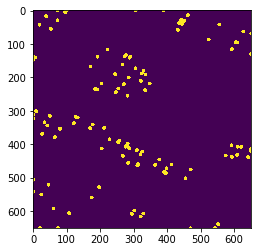

In [8]:
plt.imshow(data_set.get_mask(data_set.test_ids[30]))

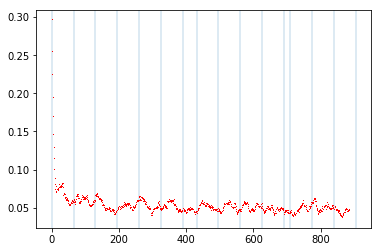

In [71]:
ws = 21
lexperiment.plot_loss(experiment.loss_history(), window_size=ws, color='r')

In [10]:
net_ = unet.VGGUnetModelWithCrop(N=40)

In [11]:
import numpy as np

In [12]:
def predict(net, X):
    X_exp = lexperiment.expand_with_mirrors(X, 104)
    xs = [0, 214]
    Y = np.ones((650,650),dtype='float32')
    Yn = np.zeros((650,650),dtype='float32')
    
    for i in xs:
        for j in xs:
            crop = X_exp[i:i+644, j:j+644, :]
            y_pred = net.predict(crop[None,:,:,:])[0,:,:,0]
            Y[i:i+436,j:j+436] *= y_pred[:,:]
            Yn[i:i+436,j:j+436] += 1.0
    return np.power(Y, 1.0/Yn)

In [72]:
net = experiment.load_net()

net_.set_weights(net.get_weights())

In [73]:
im_id = data_set.test_ids[35]
X = data_set.get_ndarray(im_id)
Y_true = data_set.get_mask(im_id)
Y_pred = predict(net_, X)

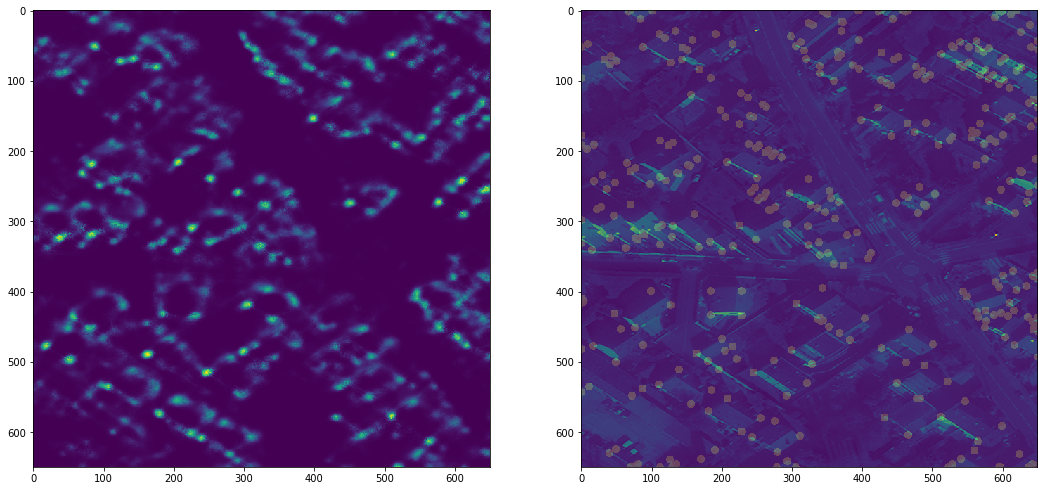

In [83]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
#plt.imshow(X[:,:,0])
plt.imshow(Y_pred)
plt.imshow(Y_true, alpha=1)
plt.imshow(Y_pred)

plt.subplot(1,2,2)
plt.imshow(X[:,:,0])
plt.imshow(Y_true, alpha=0.2)